In [ ]:
!pip install pytesseract
!pip install fpdf

In [1]:
import cv2
import numpy as np
import pytesseract

In [9]:
from pytesseract.pytesseract import Output
# import the necessary packages
from imutils.object_detection import non_max_suppression
import numpy as np
import pytesseract
import argparse
import cv2

def decode_predictions(scores, geometry):
	# grab the number of rows and columns from the scores volume, then
	# initialize our set of bounding box rectangles and corresponding
	# confidence scores
	(numRows, numCols) = scores.shape[2:4]
	rects = []
	confidences = []

	# loop over the number of rows
	for y in range(0, numRows):
		# extract the scores (probabilities), followed by the
		# geometrical data used to derive potential bounding box
		# coordinates that surround text
		scoresData = scores[0, 0, y]
		xData0 = geometry[0, 0, y]
		xData1 = geometry[0, 1, y]
		xData2 = geometry[0, 2, y]
		xData3 = geometry[0, 3, y]
		anglesData = geometry[0, 4, y]

		# loop over the number of columns
		for x in range(0, numCols):
			# if our score does not have sufficient probability,
			# ignore it
			if scoresData[x] < 0.01:
				continue

			# compute the offset factor as our resulting feature
			# maps will be 4x smaller than the input image
			(offsetX, offsetY) = (x * 4.0, y * 4.0)

			# extract the rotation angle for the prediction and
			# then compute the sin and cosine
			angle = anglesData[x]
			cos = np.cos(angle)
			sin = np.sin(angle)

			# use the geometry volume to derive the width and height
			# of the bounding box
			h = xData0[x] + xData2[x]
			w = xData1[x] + xData3[x]

			# compute both the starting and ending (x, y)-coordinates
			# for the text prediction bounding box
			endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
			endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
			startX = int(endX - w)
			startY = int(endY - h)

			# add the bounding box coordinates and probability score
			# to our respective lists
			rects.append((startX, startY, endX, endY))
			confidences.append(scoresData[x])

	# return a tuple of the bounding boxes and associated confidences
	return (rects, confidences)

In [2]:
def sort_by_per(emp):
  return emp.percent

class Checkpoint(object):

    def __init__(self, picture, percent, time):
        """Constructor"""
        self.pic = picture
        self.percent = percent
        self.time = time



In [11]:
def analyzer(img, coef = 0.01):

  image = img
  orig = image.copy()
  (origH, origW) = image.shape[:2]
  (newW, newH) = (320, 320)
  rW = origW / float(newW)
  rH = origH / float(newH)
  image = cv2.resize(image, (newW, newH))
  (H, W) = image.shape[:2]
  layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]
  net = cv2.dnn.readNet('frozen_east_text_detection.pb')
  blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
                               (123.68, 116.78, 103.94), swapRB=True, crop=False)
  net.setInput(blob)
  (scores, geometry) = net.forward(layerNames)
  (rects, confidences) = decode_predictions(scores, geometry)
  boxes = non_max_suppression(np.array(rects), probs=confidences)
  results = []
  for (startX, startY, endX, endY) in boxes:
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)
    dX = int((endX - startX) * 0.0)
    dY = int((endY - startY) * 0.0)
    startX = max(0, startX - dX)
    startY = max(0, startY - dY)
    endX = min(origW, endX + (dX * 2))
    endY = min(origH, endY + (dY * 2))
    roi = orig[startY:endY, startX:endX]
    config = ("-l eng --oem 1 --psm 7")
    text = ""
    results.append(((startX, startY, endX, endY), text))
  results = sorted(results, key=lambda r:r[0][1])
  output = orig.copy()
  sm_pl = 0
  for ((startX, startY, endX, endY), text) in results:
    sm = (endX-startX)*(endY-startY)
    sm_pl += sm
    cv2.rectangle(output, (startX, startY), (endX, endY),	(0, 0, 255), 2)
  height, width, _ = img.shape
  cv2.putText(output, str(round((sm_pl/(height*width)), 2)), (startX+100, startY+100),
		cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 50, 47), 3)
  return(round((sm_pl/(height*width)), 2))

In [ ]:
evsix = []
upfive = []
vals = []


video = cv2.VideoCapture('/content/минута.mp4')
fps = video.get(cv2.CAP_PROP_FPS)
frame_interval = int(fps * 0.5)
t_ct = 0
while video.isOpened():
    ret, orig = video.read()
    if not ret:
        break
    current_time = video.get(cv2.CAP_PROP_POS_MSEC) / 1000.0

    if current_time >= t_ct * 0.5:
      val = Checkpoint(orig, analyzer(orig.copy()), t_ct*0.5)
      t_ct+=1
      print(val.time)
      evsix.append(val)
      if len(evsix) == 5:
        evsix.sort(key=sort_by_per)
        upfive.append(evsix[4])
        evsix = []
      if len(upfive) == 5:
        upfive.sort(key=sort_by_per)
        vals.append(upfive[4])
        upfive = []

video.release()
if len(evsix) > 0:
  evsix = evsix.sort(key=sort_by_per)
  upfive.append(evsix[len(evsix)-1])
  evsix = []
if len(upfive) > 0:
  upfive = upfive.sort(key=sort_by_per)
  vals.append(upfive[len(upfive)-1])
  upfive = []

In [54]:
vals

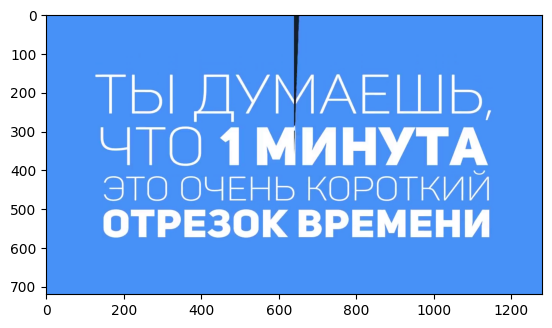

In [56]:
from matplotlib import pyplot as plt
import cv2

frame = vals[0].pic
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame_rgb)
plt.show()


In [51]:
vals[2].time

0.56

In [25]:
from fpdf import FPDF
import pysrt

class PDF(FPDF):
    def header(self):
        pass

subs = pysrt.open('74794e4e-c8d7-4770-80a2-776e37dc0515.srt', encoding='utf-8')

pdf = PDF()
pdf.add_page()
pdf.add_font('DejaVu', '', 'DejaVuSans.ttf', uni=True)
pdf.set_font('DejaVu', size=12)

for sub in subs:
    text = f"{sub.start} --> {sub.end}\n {sub.text}"
    pdf.multi_cell(0, 10, text)

pdf.output("result.pdf")


''